<a href="https://colab.research.google.com/github/pj0620/minesweeper-cnn/blob/main/generate_minesweeper_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import random
from typing import Callable, Any

import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Define game object

In [148]:
class Game:
    def __init__(self, N=10, n_bombs=10, seed=None):
        self.N = N
        self.n_bombs = n_bombs

        # convert the following to use numpy arrays
        self.bomb = np.zeros((N, N), dtype=np.int16)
        self.known = np.zeros((N, N), dtype=np.int16)

        self.gaussian_kernal = np.ones((3, 3))

        # assert that there are no more bombs than there are cells
        assert n_bombs <= N * N

        if seed is not None:
            random.seed(seed)

        placed = 0
        while placed < n_bombs:
            x = random.randint(0, N - 1)
            y = random.randint(0, N - 1)

            if self.bomb[x][y] == 0:
                self.bomb[x][y] = 1
                placed += 1

        self.values = self.compute_values()

    def compute_values(self):
        return convolve2d(self.bomb, self.gaussian_kernal, mode='same').astype(np.int16)

    # input: ch0 -> known values, ch1 known locations
    # output: ch0 -> guessable bombs
    def get_input_output_representation(self):
        guessable_mask = convolve2d(self.known, self.gaussian_kernal, mode='same').astype(float)

        # throw out cells we know
        guessable_mask *= 1.0 - self.known.astype(float)

        # round up all values > 0 to 1
        self.guessable_mask = np.where(guessable_mask > 0, 1, guessable_mask).astype(np.int16)

        # get all bombs in knowable area
        guessable_bombs = self.bomb * self.guessable_mask

        return np.dstack((self.known * self.values, self.known)), guessable_bombs

    # ** must be called after get_input_output_representation **
    # clicks safe spot in guessable region
    # returns True -> game over, False -> game not over
    def safe_next_click(self):
        clicked = False
        for x in range(0, N-1):
          for y in range(0, N-1):
            if int(self.guessable_mask[x][y]) == 0:
              continue
            if self.bomb[x][y] == 0:
              g.click(x, y)
              return False
        return True

    def click(self, x, y):
        # print you lost in red text if user clicked a bomb
        if self.bomb[x][y] == 1:
            print("\033[31mYou lost!\033[0m")
            return True

        # # propagate click according to rules of minesweeper
        self.propagate_click(x, y)

        return False

    def propagate_click(self, x, y):
        if x < 0 or x >= self.N:
            return
        if y < 0 or y >= self.N:
            return

        # if the cell is already known, do nothing
        if self.known[x][y] == 1:
            return
        self.known[x][y] = 1

        # if the cell is known to be safe, propagate click
        if self.values[x][y] == 0:
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if i == 0 and j == 0:
                        continue
                    self.propagate_click(x + i, y + j)


    def print_bombs(self):
        self.print_board_values('BOMBS', lambda x, y: f'{self.bomb[x][y]} ')

    def print_known(self):
        self.print_board_values('KNOWN', lambda x, y: f'{self.known[x][y]} ')

    def print_values(self):
        self.print_board_values('VALUES', lambda x, y: f'{self.values[x][y]} ')

    def print_board(self, marker=None, flags=None):
        def print_value(x, y):
            if (marker is not None) and (marker == (x, y)):
                return f"\033[32;5m📍\033[0m"
            elif (flags is not None) and ((x, y) in flags):
                return '🚩'
            elif self.known[x][y] == 0:
                return '🟩'
            elif self.values[x][y] > 0:
                return str(int(self.values[x][y])) + ' '
            else:
                return '  '

        self.print_board_values('BOARD', print_value)

    def print_board_values(self, title: str, operation: Callable[[int, int], Any]) -> None:
        title_space = f' {title} '
        print("#" * (self.N - len(title_space) // 2) + title_space + "#" * (self.N - len(title_space) // 2))
        for x in range(self.N):
            for y in range(self.N):
                print(operation(x, y), end="")
            print("|")

# Play interactive game
Optional

In [ ]:
N = 10
g = Game(N=N)
marker = (0, 0)
flags = set()

lost = False
while not lost:
    g.print_board(marker=marker, flags=flags)
    move = input("Enter your move(l,r,d,u to move / c to click / f,r to flag): ")
    for move_k in move.strip():
        if move_k == 'u':
            marker = (max(marker[0]-1, 0), marker[1])
        elif move_k == 'd':
            marker = (min(marker[0]+1, N-1), marker[1])
        elif move_k == 'l':
            marker = (marker[0], max(marker[1]-1, 0))
        elif move_k == 'r':
            marker = (marker[0], min(marker[1]+1, N-1))

        elif move_k == 'c':
            lost = g.click(marker[0], marker[1])

        elif move_k == 'f':
            flags.add(marker)
        elif move_k == 'r':
            flags.remove(marker)


# finding guessable mask + guessable bombs

### Input
channel 0: g.known * g.values

channel 1: g.known

### Output:
channel 0: g.bomb * guessable_mask

################# BOARD #################
                1 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
      1 1 1     1 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
      1 🟩1     1 2 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
  1 1 2 1 1       2 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
  1 🟩1           1 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
  1 1 1         1 2 🟩🟩🟩🟩🟩🟩1 1 2 🟩|
            1 1 2 🟩🟩🟩🟩🟩🟩1 1   1 1 |
            1 🟩2 1 1 1 1 2 🟩1         |
  1 1 1 1 1 2 1 1         1 🟩1         |
  1 🟩🟩🟩🟩🟩1           1 1 1         |
  2 🟩2 1 2 🟩1                         |
  1 🟩1   1 1 1                         |
  1 1 1           1 1 1                 |
                  1 🟩1                 |
                1 2 2 1                 |
        1 1 1   1 🟩1                   |
        1 🟩1   2 🟩2   1 1 1           |
        1 1 1   1 🟩1   1 🟩1           |
                1 1 1   1 1 1           |
                                        |



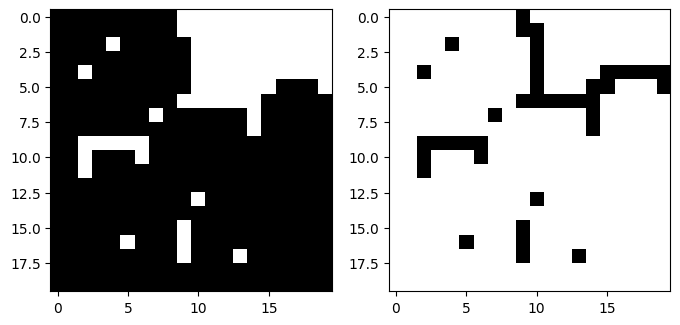

clicking (0, 9)
################# BOARD #################
                1 2 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
      1 1 1     1 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
      1 🟩1     1 2 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
  1 1 2 1 1       2 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
  1 🟩1           1 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
  1 1 1         1 2 🟩🟩🟩🟩🟩🟩1 1 2 🟩|
            1 1 2 🟩🟩🟩🟩🟩🟩1 1   1 1 |
            1 🟩2 1 1 1 1 2 🟩1         |
  1 1 1 1 1 2 1 1         1 🟩1         |
  1 🟩🟩🟩🟩🟩1           1 1 1         |
  2 🟩2 1 2 🟩1                         |
  1 🟩1   1 1 1                         |
  1 1 1           1 1 1                 |
                  1 🟩1                 |
                1 2 2 1                 |
        1 1 1   1 🟩1                   |
        1 🟩1   2 🟩2   1 1 1           |
        1 1 1   1 🟩1   1 🟩1           |
                1 1 1   1 1 1           |
                                        |


In [149]:
N = 20
g = Game(N=N, n_bombs=25, seed = 2252)
g.click(5,5)
g.print_board()
print('')

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(1 - g.known, cmap='gray')

kernal = np.array([
    [1, 1, 1, ],
    [1, 1, 1, ],
    [1, 1, 1, ],
])

guessable_mask = convolve2d(g.known, kernal, mode='same').astype(float)

# throw out cells we know
guessable_mask *= 1.0 - g.known.astype(float)

# round up all values > 0 to 1
guessable_mask = np.where(guessable_mask > 0, 1, guessable_mask).astype(np.int16)

# get all bombs in knowable area
guessable_bombs = g.bomb * guessable_mask

plt.subplot(1, 2, 2)
plt.imshow(1-guessable_mask, cmap='gray')
plt.show()

should_break = False
for x in range(0, N-1):
  if should_break:
    break
  for y in range(0, N-1):
    if int(guessable_mask[x][y]) == 0:
      continue
    if g.bomb[x][y] == 0:
      print(f'clicking {(x,y)}')
      g.click(x, y)
      should_break = True
      break

g.print_board()

# play game and generate test data

################# BOARD #################
                1 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
      1 1 1     1 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
      1 🟩1     1 2 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
  1 1 2 1 1       2 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
  1 🟩1           1 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩|
  1 1 1         1 2 🟩🟩🟩🟩🟩🟩1 1 2 🟩|
            1 1 2 🟩🟩🟩🟩🟩🟩1 1   1 1 |
            1 🟩2 1 1 1 1 2 🟩1         |
  1 1 1 1 1 2 1 1         1 🟩1         |
  1 🟩🟩🟩🟩🟩1           1 1 1         |
  2 🟩2 1 2 🟩1                         |
  1 🟩1   1 1 1                         |
  1 1 1           1 1 1                 |
                  1 🟩1                 |
                1 2 2 1                 |
        1 1 1   1 🟩1                   |
        1 🟩1   2 🟩2   1 1 1           |
        1 1 1   1 🟩1   1 🟩1           |
                1 1 1   1 1 1           |
                                        |


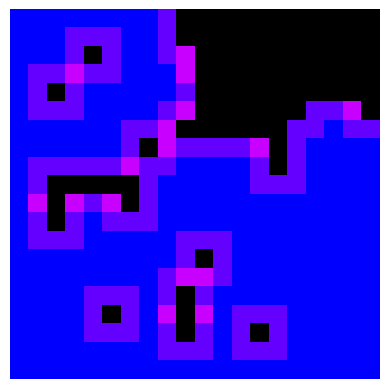

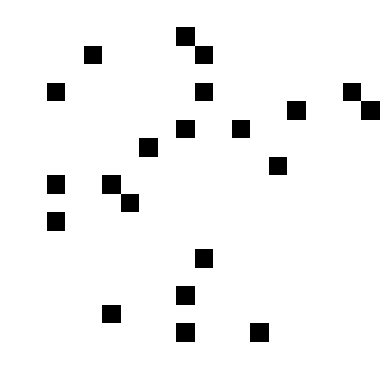

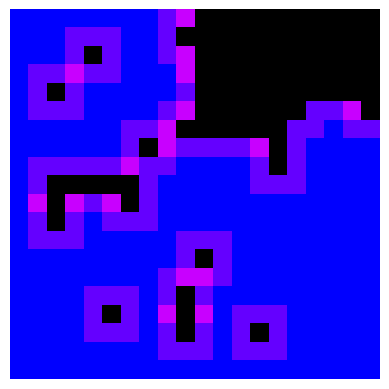

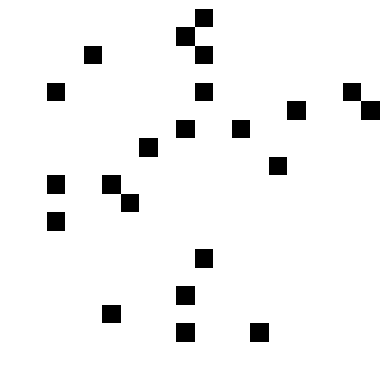

In [152]:
N = 20
g = Game(N=N, n_bombs=25, seed = 2252)
game_over = g.click(5,5)
g.print_board()

input, output = g.get_input_output_representation()

rgb_image = np.zeros((input.shape[0], input.shape[1], 3), dtype=np.uint8)
rgb_image[:, :, 0] = 100 * input[:, :, 0]  # Values
rgb_image[:, :, 2] = 255 * input[:, :, 1]  # Known

# Display the RGB image
plt.imshow(rgb_image)
plt.axis('off')  # Hide axis ticks and labels
plt.show()

plt.imshow(1-output, cmap='gray')
plt.axis('off')
plt.show()

g.safe_next_click()

input, output = g.get_input_output_representation()

rgb_image = np.zeros((input.shape[0], input.shape[1], 3), dtype=np.uint8)
rgb_image[:, :, 0] = 100 * input[:, :, 0]  # Values
rgb_image[:, :, 2] = 255 * input[:, :, 1]  # Known

# Display the RGB image
plt.imshow(rgb_image)
plt.axis('off')  # Hide axis ticks and labels
plt.show()

plt.imshow(1-output, cmap='gray')
plt.axis('off')
plt.show()

